In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load the data

In [4]:
from sqlalchemy import create_engine


driver = 'mysql+pymysql:'
user = 'adria'
password = '00000'
ip = '35.187.114.125'
database = 'vimet'

connection_string = f'{driver}//{user}:{password}@{ip}/{database}'
engine = create_engine(connection_string)

In [5]:
items = pd.read_sql('items', con = engine)

Before looking at similarities, we will drop the orders related to 'El Gran Recapte' as they are considered outliers

In [6]:
items = items[items['Vendor'] != 'Gran Recapte']

We will also drop the orders with tag 'Cesta' as they refer to a new method of selling and are also considered outliers

In [7]:
items = items[items['tags'] != 'Cesta']

### Create a data frame that contains the total quantity of each product purchased by each order

In [8]:
rec = items.groupby(['Name', 'tags']).sum()[['Lineitem quantity']]

### Create a product by order matrix

In [9]:
df_pivot = rec.pivot_table(index='tags', columns='Name', values='Lineitem quantity').fillna(0)
df_pivot.head()

Name      #1001  #1002  #1003  #1004  #1005  #1006  #1007  #1008  #1009  \
tags                                                                      
Aceite      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Acelgas     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Agua        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Aguacate    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Ajo         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

Name      #1010  ...  #1239  #1240  #1241  #1242  #1243  #1244  #1245  #1246  \
tags             ...                                                           
Aceite      0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Acelgas     0.0  ...    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
Agua        0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Aguacate    0.0  ...    0.0    1.0    0.0    0.0    0.0    0.0    0.0    1.0   
Ajo         0.0  ...    1.0    1.0    0.0    0.0    1.0    0.0    0.0    1.0   

Name      #1247  #1248  
tags                    
Aceite      0.0    0.0  
Acelgas     0.0    0.0  
Agua        0.0    0.0  
Aguacate    0.0    0.0  
Ajo         0.0    0.0  

[5 rows x 203 columns]

### Create an order similarity matrix

In [10]:
from scipy.spatial.distance import pdist, squareform
similarity_matrix = squareform(pdist(df_pivot.T, 'cosine'))
similarity_matrix

array([[0.        , 1.        , 1.        , ..., 0.84382624, 0.79148559,
        1.        ],
       [1.        , 0.        , 1.        , ..., 0.84382624, 0.79148559,
        1.        ],
       [1.        , 1.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.84382624, 0.84382624, 1.        , ..., 0.        , 0.60922623,
        0.6095656 ],
       [0.79148559, 0.79148559, 1.        , ..., 0.60922623, 0.        ,
        0.65247598],
       [1.        , 1.        , 1.        , ..., 0.6095656 , 0.65247598,
        0.        ]])

### Top 5 most similar orders for a specific order.

In [11]:
similarity_df = pd.DataFrame(similarity_matrix, index=df_pivot.columns, columns=df_pivot.columns)

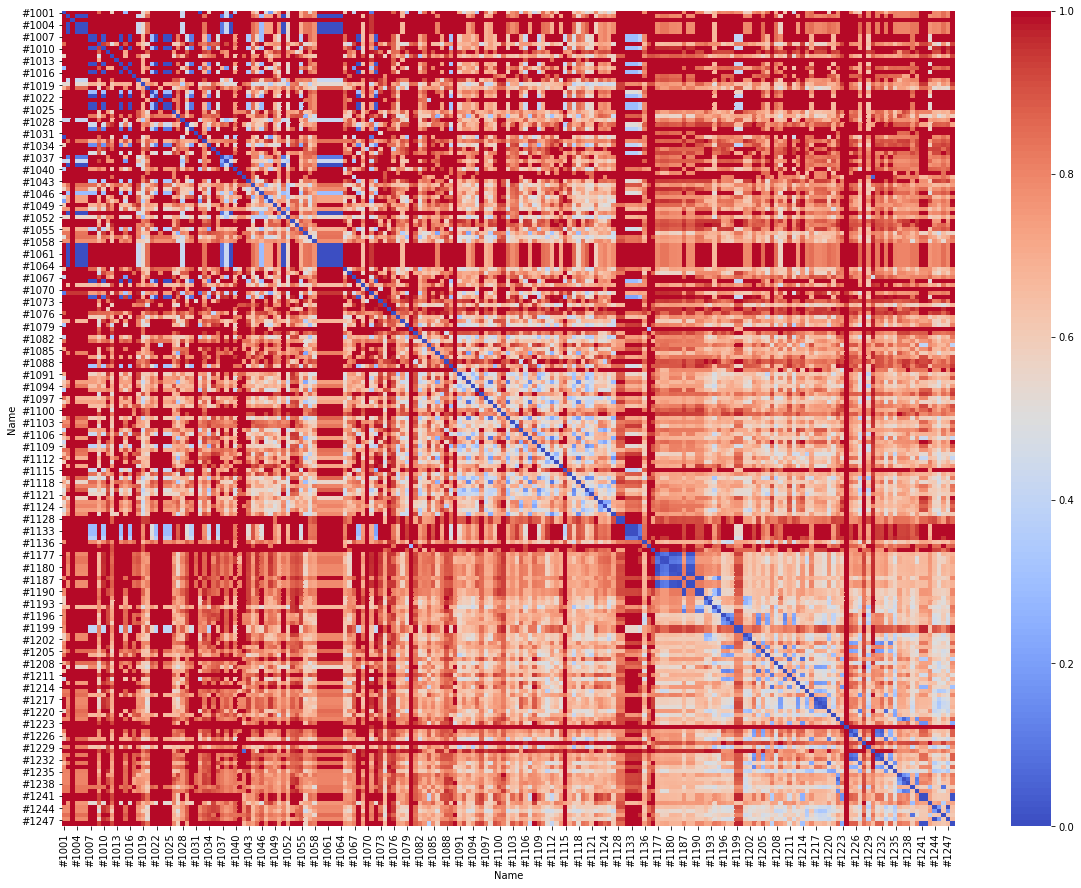

In [12]:
plt.figure(figsize=(20,15))
cmap = sns.color_palette("coolwarm", 128)
sns.heatmap(similarity_df, cmap=cmap)

plt.show()

We see that orders #1061, #1064, #1004 are very similiar, let's take a look at the items they have to check whether the similarity is calculated correclty

In [13]:
items[items['Name'] == '#1061']

index   Name  Lineitem quantity        Lineitem name  Lineitem price  \
2685   2685  #1061                  1  Huevos - 1/2 docena             1.5   

     Lineitem fulfillment status               Cancelled at  Refunded Amount  \
2685                     pending  2017-09-15 21:34:12 +0200              0.0   

             Vendor  Lineitem discount    tags  
2685  Aviram Mónica                  0  Huevos

In [14]:
items[items['Name'] == '#1064']

index   Name  Lineitem quantity        Lineitem name  Lineitem price  \
2682   2682  #1064                  1  Huevos - 1/2 docena             1.5   

     Lineitem fulfillment status               Cancelled at  Refunded Amount  \
2682                     pending  2017-09-15 21:33:34 +0200              0.0   

             Vendor  Lineitem discount    tags  
2682  Aviram Mónica                  0  Huevos

In [15]:
items[items['Name'] == '#1004']

index   Name  Lineitem quantity        Lineitem name  Lineitem price  \
3116   3116  #1004                  1  Huevos - 6 unidades             1.5   

     Lineitem fulfillment status               Cancelled at  Refunded Amount  \
3116                     pending  2017-06-27 17:18:38 +0200              1.5   

             Vendor  Lineitem discount    tags  
3116  Aviram Mónica                  0  Huevos

In [16]:
items[items['Name'] == '#1007']

index   Name  Lineitem quantity                 Lineitem name  \
3113   3113  #1007                  1  Culata al corte - 2 unidades   

      Lineitem price Lineitem fulfillment status   Cancelled at  \
3113             7.5                     pending  not cancelled   

      Refunded Amount            Vendor  Lineitem discount     tags  
3113              0.0  Carnicería Vidal                  0  Ternera

In [17]:
items[items['Name'] == '#1025']

index   Name  Lineitem quantity                       Lineitem name  \
3005   3005  #1025                  1     Mitjana deshuesada - 2 unidades   
3006   3006  #1025                  2  Hamburguesas de queso - 2 unidades   

      Lineitem price Lineitem fulfillment status   Cancelled at  \
3005             8.0                     pending  not cancelled   
3006             3.0                     pending  not cancelled   

      Refunded Amount            Vendor  Lineitem discount     tags  
3005              0.0  Carnicería Vidal                  0  Ternera  
3006              0.0  Carnicería Vidal                  0  Ternera

We define a new DataFrame with all the distances below 0.1. This will identify the most similar orders.

In [18]:
level_1 = similarity_df[similarity_df  < 0.1]

In [19]:
level_1.head()

Name   #1001  #1002  #1003  #1004  #1005  #1006  #1007  #1008  #1009  #1010  \
Name                                                                          
#1001    0.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
#1002    NaN    0.0    NaN    0.0    0.0    0.0    NaN    NaN    NaN    NaN   
#1003    NaN    NaN    0.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
#1004    NaN    0.0    NaN    0.0    0.0    0.0    NaN    NaN    NaN    NaN   
#1005    NaN    0.0    NaN    0.0    0.0    0.0    NaN    NaN    NaN    NaN   

Name   ...  #1239  #1240  #1241  #1242  #1243  #1244  #1245  #1246  #1247  \
Name   ...                                                                  
#1001  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
#1002  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
#1003  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
#1004  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
#1005  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

Name   #1248  
Name          
#1001    NaN  
#1002    NaN  
#1003    NaN  
#1004    NaN  
#1005    NaN  

[5 rows x 203 columns]

Let's check two similar (not equal) orders for a given order

In [ ]:
# Posar aqui la funció de recommender